In [51]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

from keras import layers
from keras.models import Sequential, Model
from keras.utils import np_utils, plot_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, ZeroPadding2D, Add, BatchNormalization
from keras.optimizers import Adam
from keras.engine.input_layer import Input
from keras.initializers import glorot_uniform


Based on article and paper analysis found at https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c

#### Loading the dataset

In [52]:
# Set class names
cifar10_classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
n_classes = 10

# Load the dataset
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

# Normalize
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train/=255
X_test/=255

Y_train = np_utils.to_categorical(y_train, len(cifar10_classes))
Y_test = np_utils.to_categorical(y_test, len(cifar10_classes))


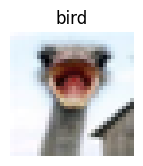

In [53]:

# Show random images from training data
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
        plt.show()
        

### Basic ResNet 18 and 34

In [54]:

# basic ResNet identity block

def building_block(X, filters, s=1):
    X_shortcut = X
    X = Conv2D(filters=filters, kernel_size=(3, 3), strides=(s, s), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    
    if s != 1:
        X_shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=(s, s), 
                            padding='valid', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X


In [74]:

def ResNet18(input_shape, n_classes):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    # 7x7x64 initial convolution layer
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    # 3x3 max pool
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 2nd conv layer of 3x3x64 identity blocks
    X = building_block(X, 64)
    X = building_block(X, 64)
    # 3rd conv layer of 3x3x128 identity blocks
    X = building_block(X, 128, s=2)
    X = building_block(X, 128)
    X = building_block(X, 256, s=2)

    X = building_block(X, 256)
    X = building_block(X, 512, s=2)
    X = building_block(X, 512)

    X = MaxPooling2D((2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(n_classes, activation='softmax', name='fc' + str(n_classes), 
              kernel_initializer=glorot_uniform(seed=0))(X)
    return Model(inputs=X_input, outputs=X, name='ResNet18')

input_shape = (32, 32, 3)
model = ResNet18(input_shape, n_classes=10)

model.summary()


Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_9 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_10[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_9[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']           

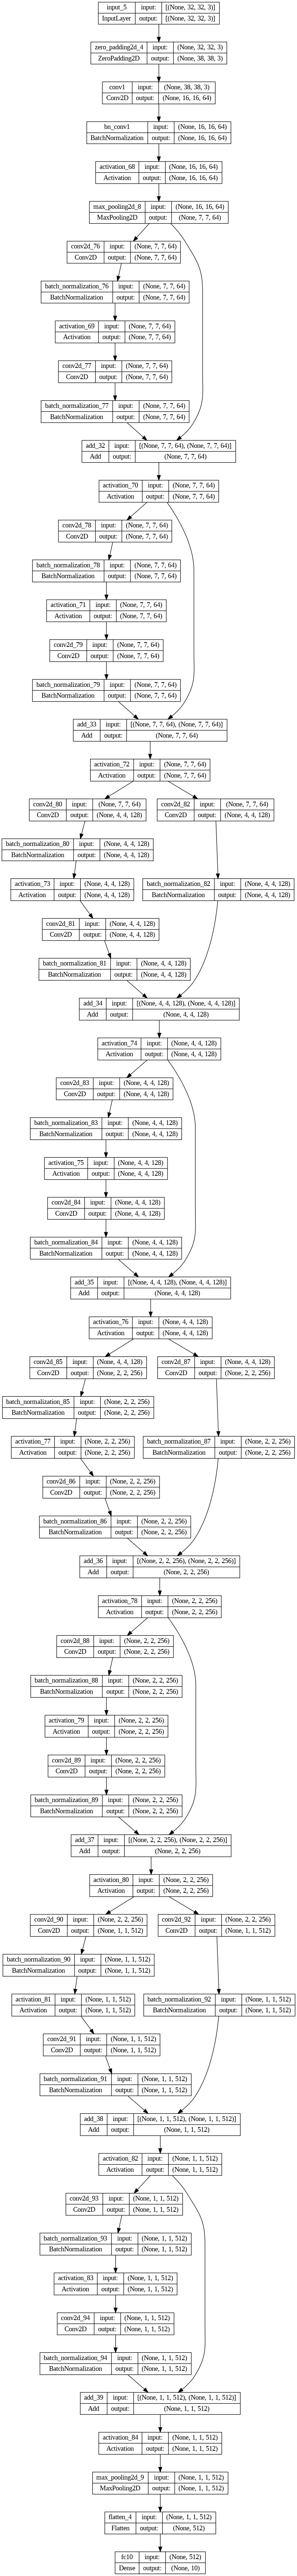

In [58]:
plot_model(model, show_shapes=True)



In [59]:

loss = "categorical_crossentropy"
model.compile(loss=loss,  optimizer="Adam", metrics=["acc"])

history = model.fit(X_train,Y_train,epochs=25)

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test accuracy: {}".format(test_accuracy))



Epoch 1/25
1563/1563 [==============================] - 47s 21ms/step - loss: 1.5215 - acc: 0.4628
Epoch 2/25
1563/1563 [==============================] - 32s 20ms/step - loss: 1.0984 - acc: 0.6193
Epoch 3/25
1563/1563 [==============================] - 32s 20ms/step - loss: 0.9315 - acc: 0.6774
Epoch 4/25
1563/1563 [==============================] - 32s 21ms/step - loss: 0.8026 - acc: 0.7247
Epoch 5/25
1563/1563 [==============================] - 31s 20ms/step - loss: 0.6836 - acc: 0.7632
Epoch 6/25
1563/1563 [==============================] - 32s 21ms/step - loss: 0.5964 - acc: 0.7937
Epoch 7/25
1563/1563 [==============================] - 31s 20ms/step - loss: 0.5131 - acc: 0.8229
Epoch 8/25
1563/1563 [==============================] - 32s 20ms/step - loss: 0.4378 - acc: 0.8481
Epoch 9/25
1563/1563 [==============================] - 31s 20ms/step - loss: 0.3506 - acc: 0.8786
Epoch 10/25
1563/1563 [==============================] - 32s 20ms/step - loss: 0.2837 - acc: 0.9018
Epoch 11/

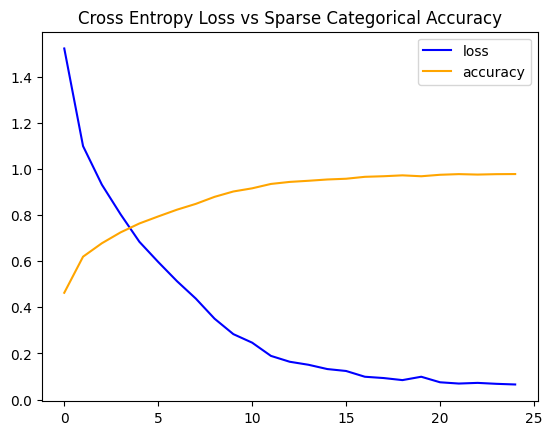

In [61]:

plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['acc'], color='orange', label='accuracy')
plt.title('Cross Entropy Loss vs Sparse Categorical Accuracy')
plt.legend()
plt.show()


In [72]:
def ResNet34(input_shape, n_classes):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 3 building blocks of 64 filters
    X = building_block(X, 64)
    X = building_block(X, 64)
    X = building_block(X, 64)

    # 4 building blocks of 128 filters
    X = building_block(X, 128, s=2)
    for _ in range(3):
        X = building_block(X, 128)

    # 6 building blocks of 256 filters
    X = building_block(X, 256, s=2)
    for _ in range(5):
        X = building_block(X, 256)
    
    # 3 building blocks of 512 filters
    X = building_block(X, 512, s=2)
    X = building_block(X, 512)
    X = building_block(X, 512)

    X = MaxPooling2D((2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(n_classes, activation='softmax', name='fc' + str(n_classes), 
              kernel_initializer=glorot_uniform(seed=0))(X)
    return Model(inputs=X_input, outputs=X, name='ResNet34')

input_shape = (32, 32, 3)
model = ResNet34(input_shape, n_classes=10)

model.summary()


Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_9[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_8[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']           

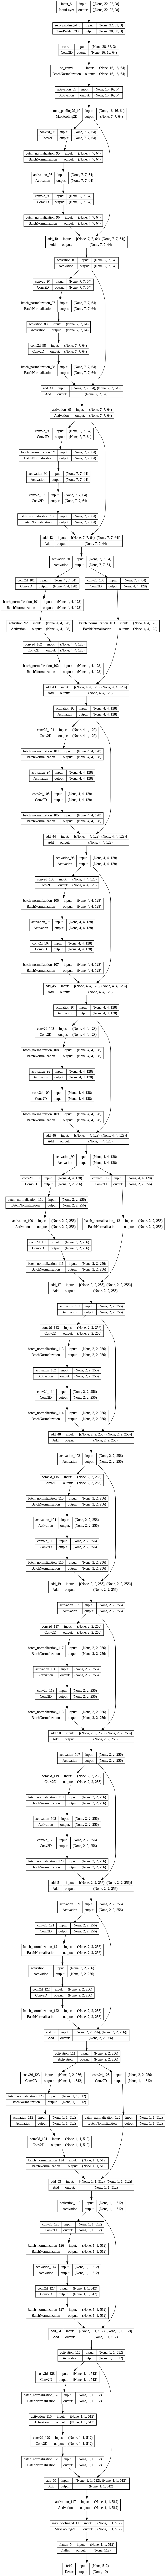

In [63]:
plot_model(model, show_shapes=True)




In [64]:

loss = "categorical_crossentropy"
model.compile(loss=loss,  optimizer="Adam", metrics=["acc"])

history = model.fit(X_train,Y_train,epochs=25)

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test accuracy: {}".format(test_accuracy))



Epoch 1/25
1563/1563 [==============================] - 77s 34ms/step - loss: 1.6193 - acc: 0.4281
Epoch 2/25
1563/1563 [==============================] - 52s 34ms/step - loss: 1.2331 - acc: 0.5773
Epoch 3/25
1563/1563 [==============================] - 52s 33ms/step - loss: 1.1085 - acc: 0.6228
Epoch 4/25
1563/1563 [==============================] - 52s 34ms/step - loss: 1.0890 - acc: 0.6299
Epoch 5/25
1563/1563 [==============================] - 53s 34ms/step - loss: 0.9323 - acc: 0.6826
Epoch 6/25
1563/1563 [==============================] - 53s 34ms/step - loss: 0.7986 - acc: 0.7272
Epoch 7/25
1563/1563 [==============================] - 54s 34ms/step - loss: 0.7485 - acc: 0.7452
Epoch 8/25
1563/1563 [==============================] - 53s 34ms/step - loss: 0.6457 - acc: 0.7802
Epoch 9/25
1563/1563 [==============================] - 53s 34ms/step - loss: 0.5544 - acc: 0.8119
Epoch 10/25
1563/1563 [==============================] - 54s 34ms/step - loss: 0.5543 - acc: 0.8137
Epoch 11/

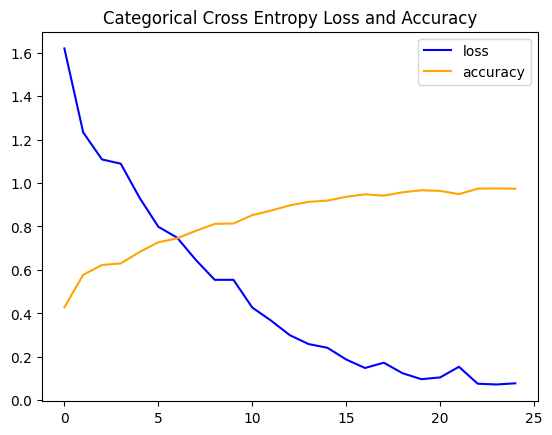

In [66]:
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['acc'], color='orange', label='accuracy')
plt.title('Categorical Cross Entropy Loss and Accuracy')
plt.legend()
plt.show()

# Bottleneck ResNet 50

In [71]:
def bottleneck_block(X, filters, s=1):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), 
               padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), 
               padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), 
               padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    if s != 1 or (filters==[64, 64, 256] and s==1):
        X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), 
                            padding='valid', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def ResNet50(input_shape, n_classes):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = bottleneck_block(X, [64, 64, 256], s=1)
    X = bottleneck_block(X, [64, 64, 256])
    X = bottleneck_block(X, [64, 64, 256])

    X = bottleneck_block(X, [128, 128, 512], s=2)
    for _ in range(3):
        X = bottleneck_block(X, [128, 128, 512])

    X = bottleneck_block(X, [256, 256, 1024], s=2)
    for _ in range(5):
        X = bottleneck_block(X, [256, 256, 1024])

    X = bottleneck_block(X, [512, 512, 2048], s=2)
    X = bottleneck_block(X, [512, 512, 2048])
    X = bottleneck_block(X, [512, 512, 2048])

    X = MaxPooling2D((2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(n_classes, activation='softmax', name='fc' + str(n_classes), 
              kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    return model
   
input_shape = (32,32,3)
model = ResNet50(input_shape, n_classes=10)
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_7 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_7[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']           

In [70]:
plot_model(model, show_shapes=True)



Output hidden; open in https://colab.research.google.com to view.

In [68]:

loss = "categorical_crossentropy"
model.compile(loss=loss,  optimizer="Adam", metrics=["acc"])

history = model.fit(X_train,Y_train,epochs=25)

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test accuracy: {}".format(test_accuracy))



Epoch 1/25
1563/1563 [==============================] - 124s 47ms/step - loss: 2.1726 - acc: 0.3299
Epoch 2/25
1563/1563 [==============================] - 73s 47ms/step - loss: 2.0003 - acc: 0.3844
Epoch 3/25
1563/1563 [==============================] - 72s 46ms/step - loss: 2.2233 - acc: 0.2997
Epoch 4/25
1563/1563 [==============================] - 72s 46ms/step - loss: 1.9191 - acc: 0.3679
Epoch 5/25
1563/1563 [==============================] - 71s 46ms/step - loss: 1.9738 - acc: 0.3503
Epoch 6/25
1563/1563 [==============================] - 72s 46ms/step - loss: 1.6870 - acc: 0.4245
Epoch 7/25
1563/1563 [==============================] - 71s 46ms/step - loss: 1.7921 - acc: 0.4058
Epoch 8/25
1563/1563 [==============================] - 71s 45ms/step - loss: 1.7883 - acc: 0.3940
Epoch 9/25
1563/1563 [==============================] - 72s 46ms/step - loss: 1.6274 - acc: 0.4340
Epoch 10/25
1563/1563 [==============================] - 72s 46ms/step - loss: 1.7458 - acc: 0.4016
Epoch 11

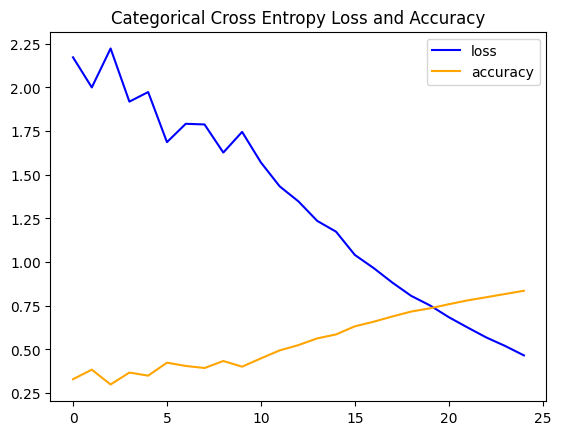

In [69]:
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['acc'], color='orange', label='accuracy')
plt.title('Categorical Cross Entropy Loss and Accuracy')
plt.legend()
plt.show()

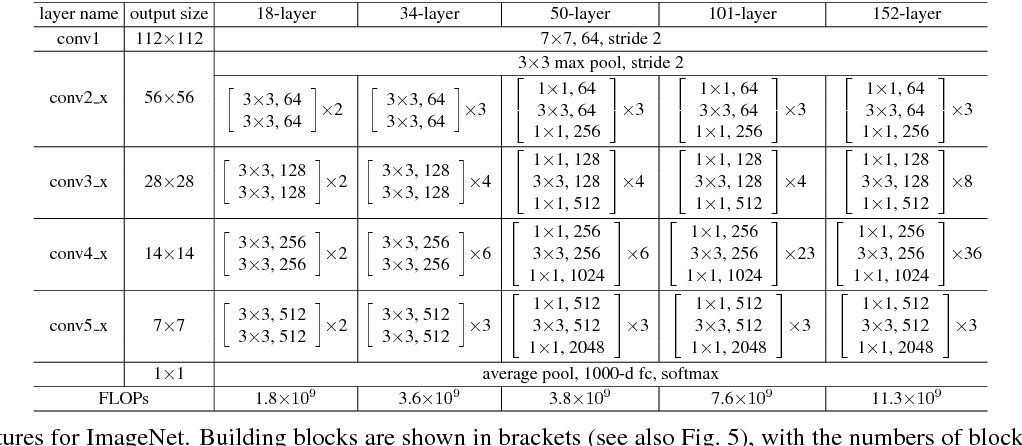